In [1]:
# Nonlinear MPC test using kinematic bicycle model for car
# We want to use the kinematic bicycle model from this paper (Figure 3)
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4

# which has states:
# x, y = positional coordinates in inertial frame
# ψ = angle of car centerline in inertial frame
# ̇ψ = change of angle
# β = angle between car centerline and velocity vector
# ̇β = change of angle

# and has the equations:
# ̇x = v cos(ψ + β)
# ̇y = v sin(ψ + β)
# ̇v = a
# ̇ψ = v / lᵣ sin(β)
# β = arctan(lᵣ/(lf + lᵣ) tan(δf))
# ̇β = v/(lf + lᵣ) tan(δf) - v/lᵣ sin(β)
# ̇δf = ω

# and we want to solve it. Define the model:


The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\\ \beta\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}
where the two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).
The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}
\end{gather*}

## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [2]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl

# Local dependencies
from direct_collocation  import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar
from roadrunner          import Roadrunner, RoadSegment
from road                import test_road, iso_double_lane_change

## Initial state and cost

In [3]:
# Initialize the car model with 0.05 second steps and 30 step lookahead
car = KinematicBicycleCar(N=30, step=0.05)
# Initial conditions: x,y = 0,0, velocity = 5.5 m/s, car at 22.5-degree angle
# This is the model:
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1/figures/3
#ic = [test_road[0,0], test_road[0,1], 5.5, np.pi/8, 0.0]
ic = [test_road[0,0], test_road[0,1], 5.5, np.pi/8]
car.set_initial(ic)

# Cost - we want the velocity to stay around 5 m/s, so we penalize deviations from that.
cost = (car.dae.x[0][2]-5)**2

In [10]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road,                    # Road centerline points
                        road_width  = np.ones(n_test_road_pts)*5.0, # constant lane width of 5 meters
                        P           = 20) # Number of points to try curve-fitting at a time

# Boundary functions

# terrible hack, need to fix right away
global prev_k
prev_k= 0
dist_already_traveled = 0.0

def road_center(model:KinematicBicycleCar, k:int):
    global prev_k
    if k == prev_k+1:
        roadrunner.advance(model.step*model.state_estimate[2,k])
        prev_k = k
    if k == 0:
        roadrunner.reset()
        roadrunner.advance(dist_already_traveled)
        prev_k = k
    center = np.empty((3,))
    center[0:2] = np.reshape(roadrunner.evaluate(),2)
    center[2]   = roadrunner.get_angle()
    return center

def upperbounds_x(model:KinematicBicycleCar, k:int):
    xy = road_center(model, k)
    bound = model.upperbounds_x(k)
    
    # Add the road width
    angle = roadrunner.get_angle()
    width = roadrunner.get_width()
    
    xy_0 = (width/2*np.cos(np.pi/2 + angle) + 2*np.cos(angle))
    bound[0] = xy[0] + xy_0*np.sign(xy_0)
    xy_1 = (width/2*np.sin(np.pi/2 + angle) + 2*np.sin(angle))
    bound[1] = xy[1] + xy_1*np.sign(xy_1)
    
    return bound

def lowerbounds_x(model:KinematicBicycleCar, k:int):
    xy = road_center(model, k)
    bound = model.lowerbounds_x(k)
    
    # Add the road width
    angle = roadrunner.get_angle()
    width = roadrunner.get_width()
    
    xy_0 = (width/2*np.cos(np.pi/2 + angle) + 2*np.cos(angle))
    bound[0] = xy[0] - xy_0*np.sign(xy_0)
    xy_1 = (width/2*np.sin(np.pi/2 + angle) + 2*np.sin(angle))
    bound[1] = xy[1] - xy_1*np.sign(xy_1)
    
    return bound

def upperbounds_u(model:KinematicBicycleCar, k:int):
    bound = model.upperbounds_u(k)
    return bound

def lowerbounds_u(model:KinematicBicycleCar, k:int):
    bound = model.lowerbounds_u(k)
    return bound


In [11]:
# What we should do now
# 1. Use the velocity estimate to "step through" the road,
#    obtaining a set of road midpoints and constraint boundaries
# 2. Add a term to the cost function that attracts the successive states to the road midpoints
# 3. Use the midpoints to initialize the variable estimate so the solver is faster.
from collections import deque

v_estimate = np.ones(car.N)*ic[2]
road_points = deque(maxlen=car.N)
dist = 0.0
roadrunner.reset()

for v in v_estimate:
    roadrunner.advance(v*car.step)
    xy = roadrunner.evaluate()
    road_points.append(np.reshape(xy,2))

# Plot test
#test = np.empty((car.N,2))
#for i, pt in enumerate(road_points):
#    test[i,:] = pt
#plt.plot(test[:,0], test[:,1])
#plt.scatter(test_road[0:3,0], test_road[0:3,1])

## Run the MPC algorithm

In [12]:
roadrunner.reset()
prev_k = 0

mpcprob = MpcProblem(car,     # casadi.DaeBuilder()
                     cost,        # casadi symbolic objective
                     upperbounds_x=upperbounds_x,
                     lowerbounds_x=lowerbounds_x,
                     upperbounds_u=upperbounds_u,
                     lowerbounds_u=lowerbounds_u,
                     road_center=road_center,
                    )

# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 20

x_plan = np.empty((mpcprob.model.n,n_runs+1))
u_plan = np.empty((mpcprob.model.m,n_runs))
x_true = np.empty((mpcprob.model.n,n_runs+1))
x_true[:,0] = ic
x_plan[:,0] = ic

boundary_up  = np.empty((n_runs,2))
boundary_low = np.empty((n_runs,2))


for k in range(n_runs):
    xk_opt, uk_opt = mpcprob.run(x_true[:,k])
    for i in range(mpcprob.model.n):
        x_plan[i,k+1] = xk_opt[i][1]
    for i in range(mpcprob.model.m):
        u_plan[i,k] = uk_opt[i][1]
    x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])
    
    dist_already_traveled += np.sqrt((x_true[0,k+1]-x_true[0,k])**2 + (x_true[1,k+1]-x_true[1,k])**2)

    boundary_up[k,:] = upperbounds_x(mpcprob.model, 0)[0:2]
    boundary_low[k,:] = lowerbounds_x(mpcprob.model, 0)[0:2]
        
    
    # hack to demonstrate changing the cost halfway through the number of runs
    #if k = n_runs//2:
        # now the cost is penalizing velocity, so the car will stop.
    #    mpcprob.set_cost(100*car.dae.x[0][2]**2)

# This was to compare the error between the prediction and
# the simulation using casadi ODE integrator
# the error is very small.
#for k in range(1,n_runs):
    #print("True:", x_true[:,k])
    #print("Pred:", x_plan[:,k])
    #print("Error:", np.linalg.norm(x_true[:,k]-x_plan[:,k],2))

# Get the planned boundaries
boundary_plan_up = np.empty((mpcprob.model.N,2))
boundary_plan_low = np.empty((mpcprob.model.N,2))
for k in range(mpcprob.model.N):
    boundary_plan_up[k,:] = upperbounds_x(mpcprob.model, k)[0:2]
    boundary_plan_low[k,:] = lowerbounds_x(mpcprob.model, k)[0:2]
    
# Add them to the boundaries for past states
boundary_up = np.concatenate([boundary_up, boundary_plan_up])
boundary_low = np.concatenate([boundary_low, boundary_plan_low])

Attracting  X_1[0] 1 to  [0.69214585 0.80908566 0.06659183]
Attracting  X_2[0] 2 to  [0.90062817 0.82358478 0.06659183]
Attracting  X_3[0] 3 to  [1.10940704 0.83846812 0.06659183]
Attracting  X_4[0] 4 to  [1.31844909 0.85370681 0.06659183]
Attracting  X_5[0] 5 to  [1.52772688 0.86927255 0.06659183]
Attracting  X_6[0] 6 to  [1.73721829 0.88513766 0.06659183]
Attracting  X_7[0] 7 to  [1.94690599 0.90127518 0.06659183]
Attracting  X_8[0] 8 to  [2.15677686 0.91765895 0.06659183]
Attracting  X_9[0] 9 to  [2.36682156 0.93426365 0.06659183]
Attracting  X_10[0] 10 to  [2.57703404 0.95106481 0.06659183]
Attracting  X_11[0] 11 to  [2.78741116 0.96803888 0.06659183]
Attracting  X_12[0] 12 to  [2.99795231 0.98516316 0.06659183]
Attracting  X_13[0] 13 to  [3.32818178 0.98468087 0.06659183]
Attracting  X_14[0] 14 to  [3.53838594 0.99873313 0.06659183]
Attracting  X_15[0] 15 to  [3.74827991 1.01278482 0.06659183]
Attracting  X_16[0] 16 to  [3.95793042 1.02680738 0.06659183]
Attracting  X_17[0] 17 to 

  15  1.5359668e-03 1.30e-06 4.23e-04  -5.7 4.26e-02  -2.0 9.91e-01 1.00e+00h  1
  16  1.4068984e-03 1.58e-06 2.39e-04  -5.7 7.18e-02  -2.5 1.00e+00 1.00e+00h  1
  17  1.2989331e-03 4.02e-07 2.10e-04  -5.7 1.89e-01  -3.0 1.00e+00 1.00e+00h  1
  18  1.1547516e-03 4.31e-07 1.56e-04  -5.7 4.22e-01  -3.4 1.00e+00 1.00e+00h  1
  19  1.0504056e-03 8.00e-05 1.06e-04  -5.7 2.23e+00    -  1.00e+00 2.50e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0640281e-03 2.95e-03 3.96e-07  -5.7 3.51e-01    -  1.00e+00 1.00e+00f  1
  21  1.0447293e-03 1.38e-04 4.36e-08  -5.7 1.12e-01    -  1.00e+00 1.00e+00h  1
  22  1.0435153e-03 5.83e-06 9.23e-10  -5.7 1.39e-02    -  1.00e+00 1.00e+00h  1
  23  1.0416843e-03 3.34e-10 3.85e-09  -8.6 1.21e-02    -  9.99e-01 1.00e+00h  1
  24  1.0416703e-03 3.94e-11 2.03e-13  -9.0 1.25e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objecti

Attracting  X_1[0] 1 to  [1.35503517 0.85640643 0.06659183]
Attracting  X_2[0] 2 to  [1.56435177 0.87202651 0.06659183]
Attracting  X_3[0] 3 to  [1.77387864 0.88794118 0.06659183]
Attracting  X_4[0] 4 to  [1.9835992  0.90412363 0.06659183]
Attracting  X_5[0] 5 to  [2.19350105 0.92054785 0.06659183]
Attracting  X_6[0] 6 to  [2.40357543 0.93718865 0.06659183]
Attracting  X_7[0] 7 to  [2.61381685 0.95402173 0.06659183]
Attracting  X_8[0] 8 to  [2.82422264 0.97102368 0.06659183]
Attracting  X_9[0] 9 to  [3.03479257 0.98817196 0.06659183]
Attracting  X_10[0] 10 to  [3.36497162 0.98713726 0.06659183]
Attracting  X_11[0] 11 to  [3.57511651 1.00119164 0.06659183]
Attracting  X_12[0] 12 to  [3.78496321 1.0152402  0.06659183]
Attracting  X_13[0] 13 to  [3.99457765 1.02925498 0.06659183]
Attracting  X_14[0] 14 to  [4.20402134 1.04321133 0.06659183]
Attracting  X_15[0] 15 to  [4.41335148 1.05708748 0.06659183]
Attracting  X_16[0] 16 to  [4.62262106 1.07086425 0.06659183]
Attracting  X_17[0] 17 to 

Total CPU secs in IPOPT (w/o function evaluations)   =      0.044
Total CPU secs in NLP function evaluations           =      0.045

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.26ms ( 83.81us)   2.27ms ( 84.20us)        27
       nlp_g  |   3.44ms (127.59us)   3.45ms (127.92us)        27
  nlp_grad_f  |   7.12ms (254.14us)   7.13ms (254.71us)        28
  nlp_hess_l  |  19.06ms (733.00us)  19.08ms (733.89us)        26
   nlp_jac_g  |  17.82ms (636.39us)  17.85ms (637.41us)        28
       total  |  97.96ms ( 97.96ms)  96.80ms ( 96.80ms)         1
Attracting  X_1[0] 1 to  [1.79482691 0.88954664 0.06659183]
Attracting  X_2[0] 2 to  [2.00456608 0.90575441 0.06659183]
Attracting  X_3[0] 3 to  [2.21448551 0.92220138 0.06659183]
Attracting  X_4[0] 4 to  [2.42457678 0.93886247 0.06659183]
Attracting  X_5[0] 5 to  [2.6348347  0.95571347 0.06659183]
Attracting  X_6[0] 6 to  [2.84525686 0.97273104 0.06659183]
Attracting  X_7


EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.87ms ( 87.09us)   2.88ms ( 87.30us)        33
       nlp_g  |   4.35ms (131.73us)   4.30ms (130.23us)        33
  nlp_grad_f  |   8.31ms (244.47us)   8.29ms (243.88us)        34
  nlp_hess_l  |  23.44ms (732.38us)  23.46ms (733.25us)        32
   nlp_jac_g  |  21.11ms (620.97us)  21.14ms (621.73us)        34
       total  | 121.70ms (121.70ms) 121.11ms (121.11ms)         1
Attracting  X_1[0] 1 to  [2.23546317 0.92385638 0.06659183]
Attracting  X_2[0] 2 to  [2.44557128 0.94053752 0.06659183]
Attracting  X_3[0] 3 to  [2.65584567 0.95740618 0.06659183]
Attracting  X_4[0] 4 to  [2.8662842  0.97443914 0.06659183]
Attracting  X_5[0] 5 to  [3.07688711 0.99161405 0.06659183]
Attracting  X_6[0] 6 to  [3.40698857 0.98994452 0.06659183]
Attracting  X_7[0] 7 to  [3.61706839 1.00400014 0.06659183]
Attracting  X_8[0] 8 to  [3.82686355 1.01804408 0.06659183]
Attracting  X_9[0] 9 to  [4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      480

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      540
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  11  7.2550121e-01 1.93e-03 9.26e-02  -1.0 1.57e+00    -  9.13e-01 1.00e+00f  1
  12  3.7614395e-01 3.71e-04 3.30e-02  -2.5 9.15e-01    -  8.36e-01 1.00e+00f  1
  13  1.7196672e-01 1.74e-02 1.81e-02  -2.5 2.51e+00    -  5.17e-01 6.14e-01f  1
  14  2.3661208e-02 3.21e-03 1.57e-02  -3.8 1.81e+00    -  5.73e-01 1.00e+00h  1
  15  2.7151670e-03 3.61e-04 8.93e-03  -3.8 1.26e+00    -  7.39e-01 1.00e+00h  1
  16  1.3095605e-03 3.81e-05 1.03e-04  -3.8 7.01e-01    -  1.00e+00 1.00e+00h  1
  17  1.2644474e-03 8.69e-07 2.13e-04  -5.7 2.13e-02  -2.0 1.00e+00 1.00e+00h  1
  18  1.2340588e-03 2.57e-06 1.62e-04  -5.7 4.86e-02  -2.5 1.00e+00 1.00e+00h  1
  19  1.1876525e-03 1.66e-05 1.62e-04  -5.7 1.46e-01  -3.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1036571e-03 3.26e-05 1.19e-04  -5.7 3.21e-01  -3.4 1.00e+00 1.00e+00h  1
  21  1.0563455e-03 2.78e-05 8.74e-05  -5.7 5.56e-01  -3.9 1.00e+00 4.24e-01h  1
  22  1.0602869e-03 1.15e-04

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      480

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      540
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   7  6.9149322e+00 7.06e-04 7.87e-01  -1.0 1.81e-01   0.0 8.79e-01 1.00e+00f  1
   8  6.3660364e+00 1.99e-04 5.45e+00  -1.7 4.54e-01    -  5.60e-01 1.00e+00f  1
   9  5.7582345e+00 1.10e-04 5.89e-02  -1.7 1.77e-01  -0.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5423198e+00 3.01e-04 4.89e-02  -2.5 3.42e-01  -1.0 6.62e-01 1.00e+00f  1
  11  3.1169932e+00 1.29e-02 3.37e-02  -2.5 7.67e-01  -1.4 7.30e-01 6.16e-01f  1
  12  2.3462113e+00 5.68e-04 3.03e-02  -2.5 3.06e-01  -1.0 1.00e+00 1.00e+00f  1
  13  2.2529300e+00 1.11e-02 3.80e-02  -2.5 7.99e+00  -1.5 1.30e-01 6.48e-02f  1
  14  1.6557300e+00 2.02e-03 2.53e-02  -2.5 2.88e-01  -1.1 1.00e+00 1.00e+00f  1
  15  1.4625009e+00 2.57e-04 2.48e-02  -3.8 1.06e-01  -0.6 1.00e+00 1.00e+00f  1
  16  1.1447235e+00 3.28e-03 2.23e-02  -3.8 2.89e-01  -1.1 1.00e+00 7.23e-01f  1
  17  1.0171484e+00 1.35e-03 2.16e-02  -3.8 1.04e-01  -0.7 1.00e+00 8.54e-01h  1
  18  8.8208819e-01 1.25e-03

   7  7.1102331e+00 7.19e-04 7.84e-01  -1.0 1.84e-01   0.0 8.77e-01 1.00e+00f  1
   8  6.5416407e+00 4.85e-04 5.50e+00  -1.7 3.88e-01    -  5.53e-01 1.00e+00f  1
   9  5.9185856e+00 2.59e-04 5.81e-02  -1.7 1.74e-01  -0.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.6676849e+00 6.72e-04 4.94e-02  -2.5 3.48e-01  -1.0 6.60e-01 1.00e+00f  1
  11  4.2266998e+00 1.98e-04 3.88e-02  -2.5 1.31e-01  -0.5 1.00e+00 1.00e+00f  1
  12  3.3920559e+00 2.49e-03 3.50e-02  -2.5 3.45e-01  -1.0 1.00e+00 7.91e-01f  1
  13  3.0403974e+00 3.70e-04 3.31e-02  -2.5 1.26e-01  -0.6 1.00e+00 1.00e+00f  1
  14  2.3617836e+00 8.77e-03 4.70e-02  -2.5 4.44e-01  -1.1 1.00e+00 8.23e-01f  1
  15  2.0945368e+00 2.62e-03 3.52e-02  -2.5 1.62e-01  -0.6 1.00e+00 1.00e+00f  1
  16  1.4948350e+00 1.25e-03 2.38e-02  -2.5 3.05e-01  -1.1 1.00e+00 1.00e+00f  1
  17  1.3061255e+00 2.60e-04 2.29e-02  -3.8 1.10e-01  -0.7 1.00e+00 1.00e+00f  1
  18  9.9195802e-01 3.01e-03

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      480

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      540
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      480

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      540
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      480

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      540
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   7  7.6498331e+00 6.54e-04 8.23e-01  -1.0 1.89e-01   0.0 8.73e-01 1.00e+00f  1
   8  7.0396507e+00 4.69e-04 5.68e+00  -1.7 4.02e-01    -  5.44e-01 1.00e+00f  1
   9  6.3744728e+00 4.27e-04 6.07e-02  -1.7 1.82e-01  -0.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0244581e+00 5.84e-04 5.03e-02  -2.5 3.59e-01  -1.0 6.55e-01 1.00e+00f  1
  11  4.5501011e+00 1.70e-04 3.99e-02  -2.5 1.35e-01  -0.5 1.00e+00 1.00e+00f  1
  12  3.6958282e+00 2.99e-03 3.61e-02  -2.5 3.55e-01  -1.0 1.00e+00 7.49e-01f  1
  13  3.3108948e+00 4.34e-04 3.44e-02  -2.5 1.30e-01  -0.6 1.00e+00 1.00e+00f  1
  14  2.8267576e+00 6.37e-03 3.96e-02  -2.5 5.63e-01  -1.1 1.00e+00 5.23e-01f  1
  15  2.5018445e+00 1.04e-03 3.02e-02  -2.5 1.29e-01  -0.6 1.00e+00 1.00e+00f  1
  16  1.7814306e+00 1.88e-03 2.57e-02  -2.5 3.29e-01  -1.1 1.00e+00 1.00e+00f  1
  17  1.5549342e+00 2.53e-04 2.45e-02  -3.8 1.18e-01  -0.7 9.95e-01 1.00e+00f  1
  18  1.2272537e+00 7.65e-03

   7  7.7815181e+00 3.72e-04 2.17e-01  -1.0 2.22e-01   0.0 9.73e-01 1.00e+00f  1
   8  7.1976456e+00 1.29e-02 1.09e+01  -1.0 5.83e-01    -  4.55e-01 1.00e+00f  1
   9  6.9338855e+00 1.12e-03 3.17e-01  -1.0 1.65e-01   0.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.9498957e+00 9.13e-04 4.98e-01  -1.7 1.34e+00    -  3.65e-01 1.00e+00f  1
  11  1.2725689e+00 2.83e-03 6.13e-02  -1.7 2.49e+00    -  6.19e-01 1.00e+00f  1
  12  3.6688055e-01 3.49e-03 3.59e-02  -2.5 3.72e+00    -  4.42e-01 1.00e+00f  1
  13  1.2321992e-01 5.41e-04 1.78e-02  -2.5 2.00e+00    -  6.01e-01 1.00e+00f  1
  14  2.0578764e-02 1.32e-03 1.40e-02  -3.8 2.32e+00    -  5.95e-01 1.00e+00h  1
  15  2.9459612e-03 5.05e-04 6.24e-03  -3.8 1.29e+00    -  7.50e-01 1.00e+00h  1
  16  1.3693473e-03 3.07e-04 2.29e-04  -3.8 1.64e+00    -  1.00e+00 1.00e+00h  1
  17  1.3648272e-03 4.47e-07 1.83e-03  -5.7 2.06e-03  -0.1 9.87e-01 1.00e+00h  1
  18  1.0806511e-03 9.84e-07

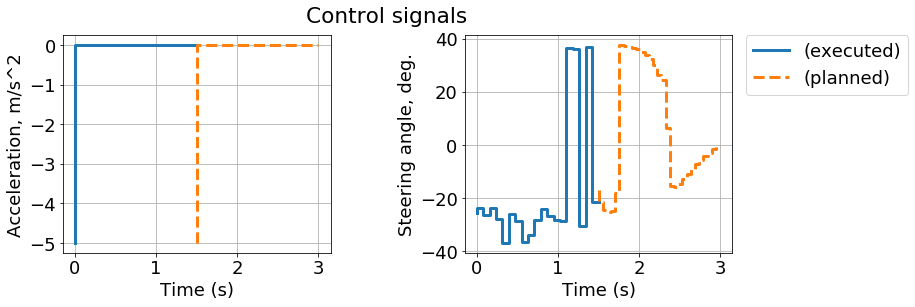

In [13]:
u_plt, u_ax1, u_ax2 = car.plot_u(u_plan, mpcprob.u_opt)
# control limits

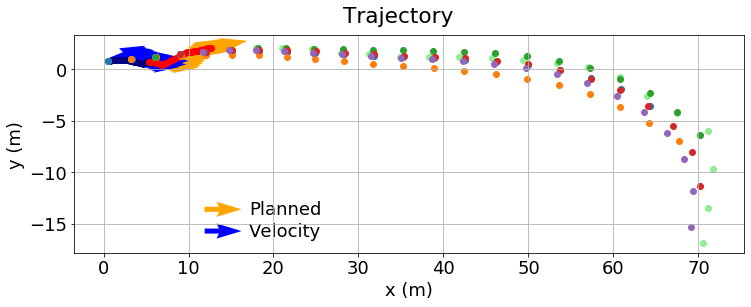

In [14]:
x_plt, x_ax = car.plot_x(x_plan, mpcprob.x_opt)
x_ax.scatter(test_road[0:25,0], test_road[0:25,1], color='lightgreen')
for i in range(0,5):
    roadrunner.segment_ptr = i
    x = np.linspace(0,1,20)
    xy = roadrunner.evaluate(x)
    #xy = roadrunner.to_world_frame(xy, roadrunner.angle[i], roadrunner.road_center[i,:])
    x_ax.scatter(xy[:,0], xy[:,1])
plt.show()

## x vs time and y vs time, separately, with the boundaries

Final state:
(x,y): 5.639172469836961 0.7388035360130911


ValueError: x and y must have same first dimension, but have shapes (16,) and (21,)

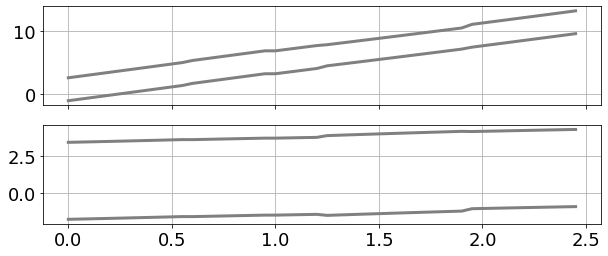

In [15]:
print("Final state:")
print("(x,y):", x_plan[0,-1], x_plan[1,-1])

fig1, ax1, ax2 = mpcprob.model.plot_with_time(x_plan, mpcprob.x_opt, boundary_up, boundary_low)

In [ ]:
# What to do:
# 1. get better data set - done
# 2. parametrize x(s) and y(s) for road
# 3. better data set should fix data fitting
# 4. better data fitting: curves should match, e.g. curve k ends with derivative k' and curve k+1 should start with derivative k'
# in that way, they are always continuous
# we can set this up (discretely) with ipopt